In [1]:
# Import libraries

from sklearn.linear_model import LinearRegression
from shapely import Point
from tqdm import tqdm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Load data
shapefile = gpd.read_file("./Shapefiles/Breda.shp")
income = pd.read_csv("./Datasets/Income.csv")
green = pd.read_csv("./Datasets/Green.csv")

# Create a key to translate income values to income brackets
incomekey = {None: "No data", 1: "€21,100 to €30,300", 2: "€30,300 to €42,800", 3: "€42,800 to €59,800", 4: "€59,800 +"}

In [3]:
# Define functions

# Identify the neighborhood coordinates belong to
def identify_neighborhood(lon, lat):
    # Convert coordinates to a point
    location = Point(lon, lat)
    try:
    # Locate the feature containing the point, and return its name
        return shapefile.loc[shapefile.geometry.contains(location), "BUURT"].iloc[0]
    except:
        return None

In [4]:
# Pre-process the data


# Copy green data
data = green

# Drop unnecessary columns
data = data.drop(columns = ["Year", "Image ID", "Date", "CBS Grid Code"])

# Change "Longitude" and "Latitude" delimiters
tqdm.pandas(desc = "Splitting coordinates...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: x.str.split(","))

# Convert "Longitude" and "Latitude" to numeric
tqdm.pandas(desc = "Converting to numeric...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: pd.to_numeric(x.str[0] + "." + x.str[1]))

# Create "Neighborhood" column and populate with neighborhood names
tqdm.pandas(desc = "Identifying neighborhoods...")
data["Neighborhood"] = data.progress_apply(lambda row: identify_neighborhood(row["Longitude"], row["Latitude"]), axis = 1)

# Create merged DataFrame
merged = data.merge(income, on = "Neighborhood", how = "left")
merged = merged.drop(columns = ["Latitude", "Longitude"])

# Create new columns with merged data 
merged["Average Green Score"] = merged.groupby("Neighborhood")["Green Score"].transform("mean")
merged["Average Income"] = merged["Income Index"].map(incomekey)

# Drop unnecessary columns and duplicate rows
merged = merged.drop(columns = ["Green Score"])
merged = merged.drop_duplicates()
merged = merged.dropna()

# Export merged DataFrame
merged.to_csv("./Datasets/Merged.csv", index = False)

# Create geodata
geodata = shapefile.merge(merged, left_on = "BUURT", right_on = "Neighborhood", how = "left")

Identifying neighborhoods...: 100%|██████████| 298038/298038 [00:29<00:00, 10051.46it/s]


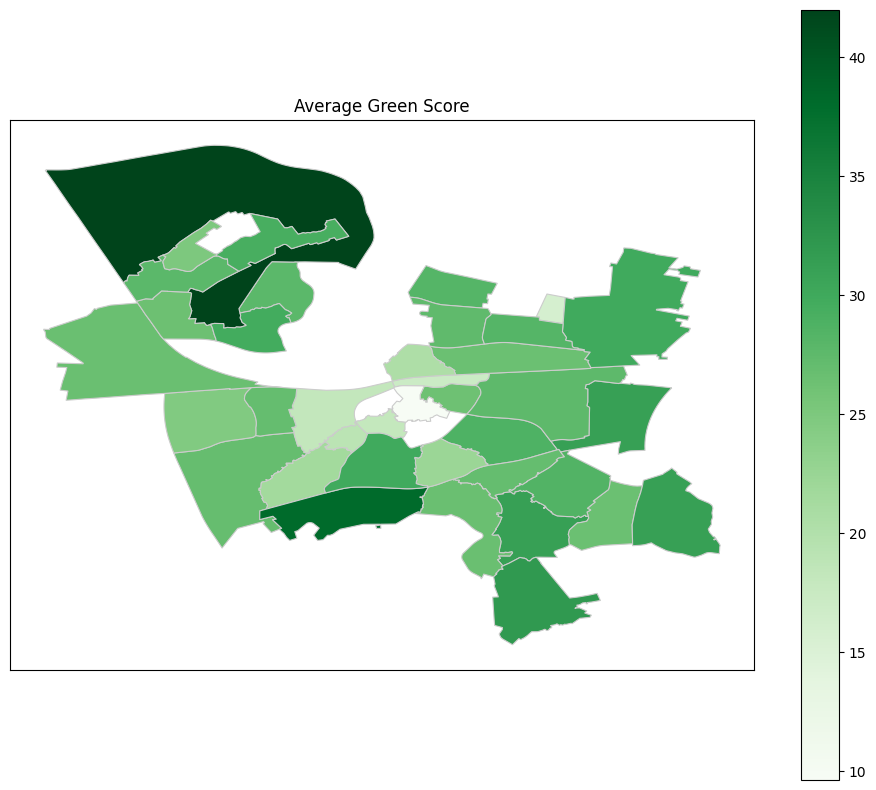

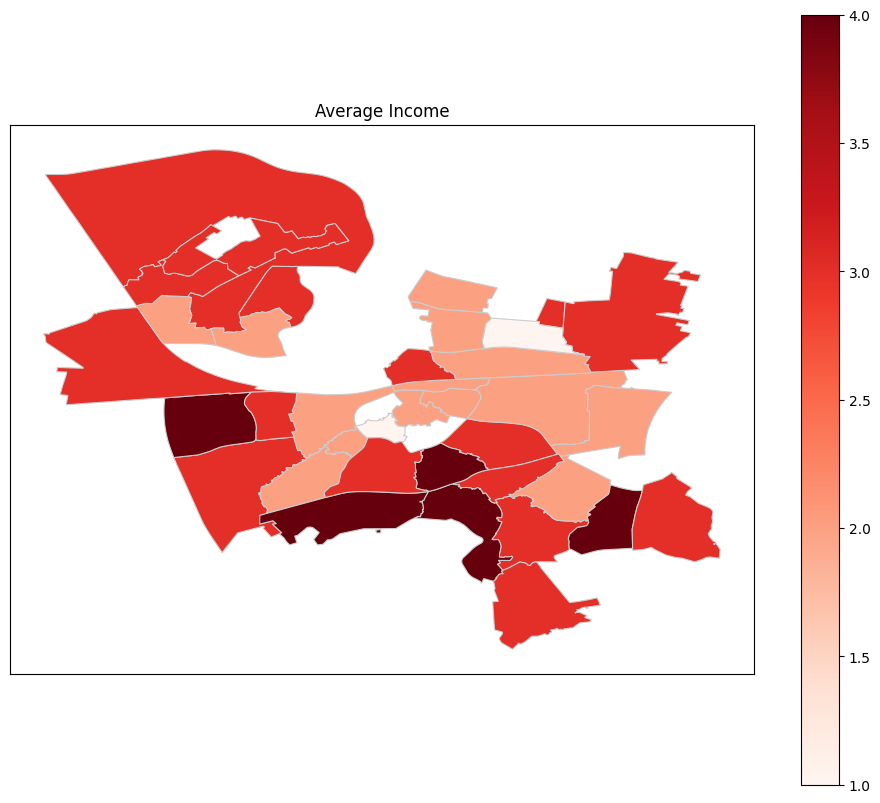

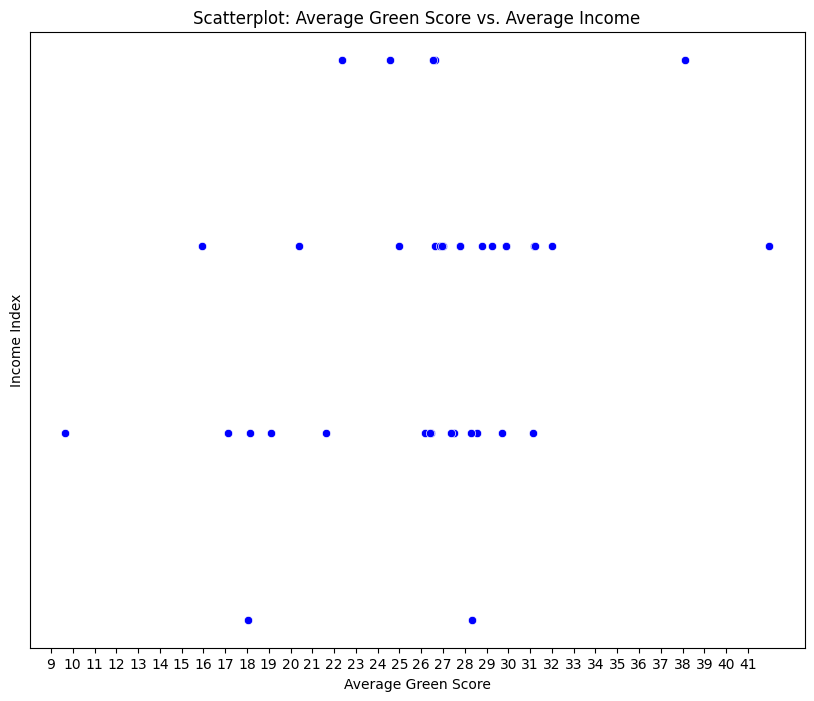

In [5]:
# Green Chloropleth Map
fig, ax = plt.subplots(figsize=(12, 10))

geodata.plot(column="Average Green Score", cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

ax.set_title("Average Green Score")

ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Red Chloropleth Map
fig, ax = plt.subplots(figsize=(12, 10))

geodata.plot(column="Income Index", cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

ax.set_title("Average Income")

ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Scatterplot
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(data=merged, x="Average Green Score", y="Income Index", color="blue")

ax.set_title("Scatterplot: Average Green Score vs. Average Income")
ax.set_yticks([])

xticks = range(int(merged["Average Green Score"].min()), int(merged["Average Green Score"].max()) + 1)

ax.set_xticks(xticks)
ax.set_xticklabels([str(incomekey) for incomekey in xticks])

plt.show()

In [6]:
"""
# Display "Average Green Score" in a chloropleth map

# Configure plot parameters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot Average Green Score chloropleth map
geodata.plot(
    column="Average Green Score",
    cmap="Greens",
    linewidth=0.8,
    ax=ax1,
    edgecolor="0.8",
    legend=True
)

# Remove axis ticks
ax1.set_xticks([])
ax1.set_yticks([])

# Set title
ax1.set_title("Average Green Score")

# Plot Average Income chloropleth map
geodata.plot(
    column="Average Income",
    cmap="Reds",
    linewidth=0.8,
    ax=ax2,
    edgecolor="0.8",
    legend=True
)

# Remove axis ticks
ax2.set_xticks([])
ax2.set_yticks([])

# Set title
ax2.set_title("Average Income")

# Filter data to include only whole-number "Income Index" values
whole_numbers = merged["Income Index"].apply(lambda x: int(x) if x.is_integer() else None)
filtered_data = merged[whole_numbers.notnull()]

# Scatterplot
sns.scatterplot(data=filtered_data, x="Income Index", y="Average Green Score", ax=ax3)

# Linear regression line
reg = LinearRegression().fit(filtered_data[["Income Index"]], filtered_data["Average Green Score"])
sns.lineplot(x=filtered_data["Income Index"], y=reg.predict(filtered_data[["Income Index"]]), color='r', ax=ax3)

# Configure plot parameters
ax3.set_xlabel("Income")
ax3.set_ylabel("Average Green Score")
ax3.set_title("Average Green Score vs Income")

# Display the plot
plt.tight_layout()
plt.show()
"""

'\n# Display "Average Green Score" in a chloropleth map\n\n# Configure plot parameters\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))\n\n# Plot Average Green Score chloropleth map\ngeodata.plot(\n    column="Average Green Score",\n    cmap="Greens",\n    linewidth=0.8,\n    ax=ax1,\n    edgecolor="0.8",\n    legend=True\n)\n\n# Remove axis ticks\nax1.set_xticks([])\nax1.set_yticks([])\n\n# Set title\nax1.set_title("Average Green Score")\n\n# Plot Average Income chloropleth map\ngeodata.plot(\n    column="Average Income",\n    cmap="Reds",\n    linewidth=0.8,\n    ax=ax2,\n    edgecolor="0.8",\n    legend=True\n)\n\n# Remove axis ticks\nax2.set_xticks([])\nax2.set_yticks([])\n\n# Set title\nax2.set_title("Average Income")\n\n# Filter data to include only whole-number "Income Index" values\nwhole_numbers = merged["Income Index"].apply(lambda x: int(x) if x.is_integer() else None)\nfiltered_data = merged[whole_numbers.notnull()]\n\n# Scatterplot\nsns.scatterplot(data=filtered